In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emg-signal-for-gesture-recognition/EMG-data.csv


We read the CSV file and Drop the unnecessary columns 


In [87]:
import pandas as pd
df = pd.read_csv("/kaggle/input/emg-signal-for-gesture-recognition/EMG-data.csv")

df = df.drop(columns=['time', 'label'])
df.drop(df[df['class'] == 0].index, inplace=True)


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1512750 entries, 2287 to 4237211
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   channel1  1512750 non-null  float64
 1   channel2  1512750 non-null  float64
 2   channel3  1512750 non-null  float64
 3   channel4  1512750 non-null  float64
 4   channel5  1512750 non-null  float64
 5   channel6  1512750 non-null  float64
 6   channel7  1512750 non-null  float64
 7   channel8  1512750 non-null  float64
 8   class     1512750 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 115.4 MB


I was extracted the features of EMG signal such as RMS, Mean absolute value,Waveform Len, Zero crossing, Slop Sign Change and variance.

Feature extraction is necessary for time-domain datasets because the raw time information does not carry discriminative power.

In [89]:
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq

def emg_features(segment):
    x = segment.values  # Pandas Series -> NumPy array
    N = len(x)

    rms = np.sqrt(np.mean(x**2))
    mav = np.mean(np.abs(x))
    wl = np.sum(np.abs(np.diff(x)))
    threshold = 1e-3
    zc = np.sum(((x[:-1] * x[1:]) < 0) & (np.abs(x[:-1] - x[1:]) > threshold))
    ssc = np.sum(((np.diff(x[:-1]) * np.diff(x[1:])) < 0))
    var = np.var(x)

    return np.array([rms, mav, wl, zc, ssc, var])


window_size = 100
step_size = 100
features = []


for start in range(0, len(df) - window_size + 1, step_size):
    window = df.iloc[start:start + window_size]
    row = {}

    for ch in ['channel1', 'channel2', 'channel3', 'channel4',
               'channel5', 'channel6', 'channel7', 'channel8']:
        
        signal = window[ch]
        rms, mav, wl, zc, ssc, var = emg_features(signal)

        row[f'{ch}_rms'] = rms
        row[f'{ch}_mav'] = mav
        row[f'{ch}_wl'] = wl
        row[f'{ch}_zc'] = zc
        row[f'{ch}_ssc'] = ssc
        row[f'{ch}_var'] = var

    
    row['class'] = window['class'].mode()[0]

    features.append(row)


df_features = pd.DataFrame(features)
df_features.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15127 entries, 0 to 15126
Data columns (total 49 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   channel1_rms  15127 non-null  float64
 1   channel1_mav  15127 non-null  float64
 2   channel1_wl   15127 non-null  float64
 3   channel1_zc   15127 non-null  float64
 4   channel1_ssc  15127 non-null  float64
 5   channel1_var  15127 non-null  float64
 6   channel2_rms  15127 non-null  float64
 7   channel2_mav  15127 non-null  float64
 8   channel2_wl   15127 non-null  float64
 9   channel2_zc   15127 non-null  float64
 10  channel2_ssc  15127 non-null  float64
 11  channel2_var  15127 non-null  float64
 12  channel3_rms  15127 non-null  float64
 13  channel3_mav  15127 non-null  float64
 14  channel3_wl   15127 non-null  float64
 15  channel3_zc   15127 non-null  float64
 16  channel3_ssc  15127 non-null  float64
 17  channel3_var  15127 non-null  float64
 18  channel4_rms  15127 non-nu

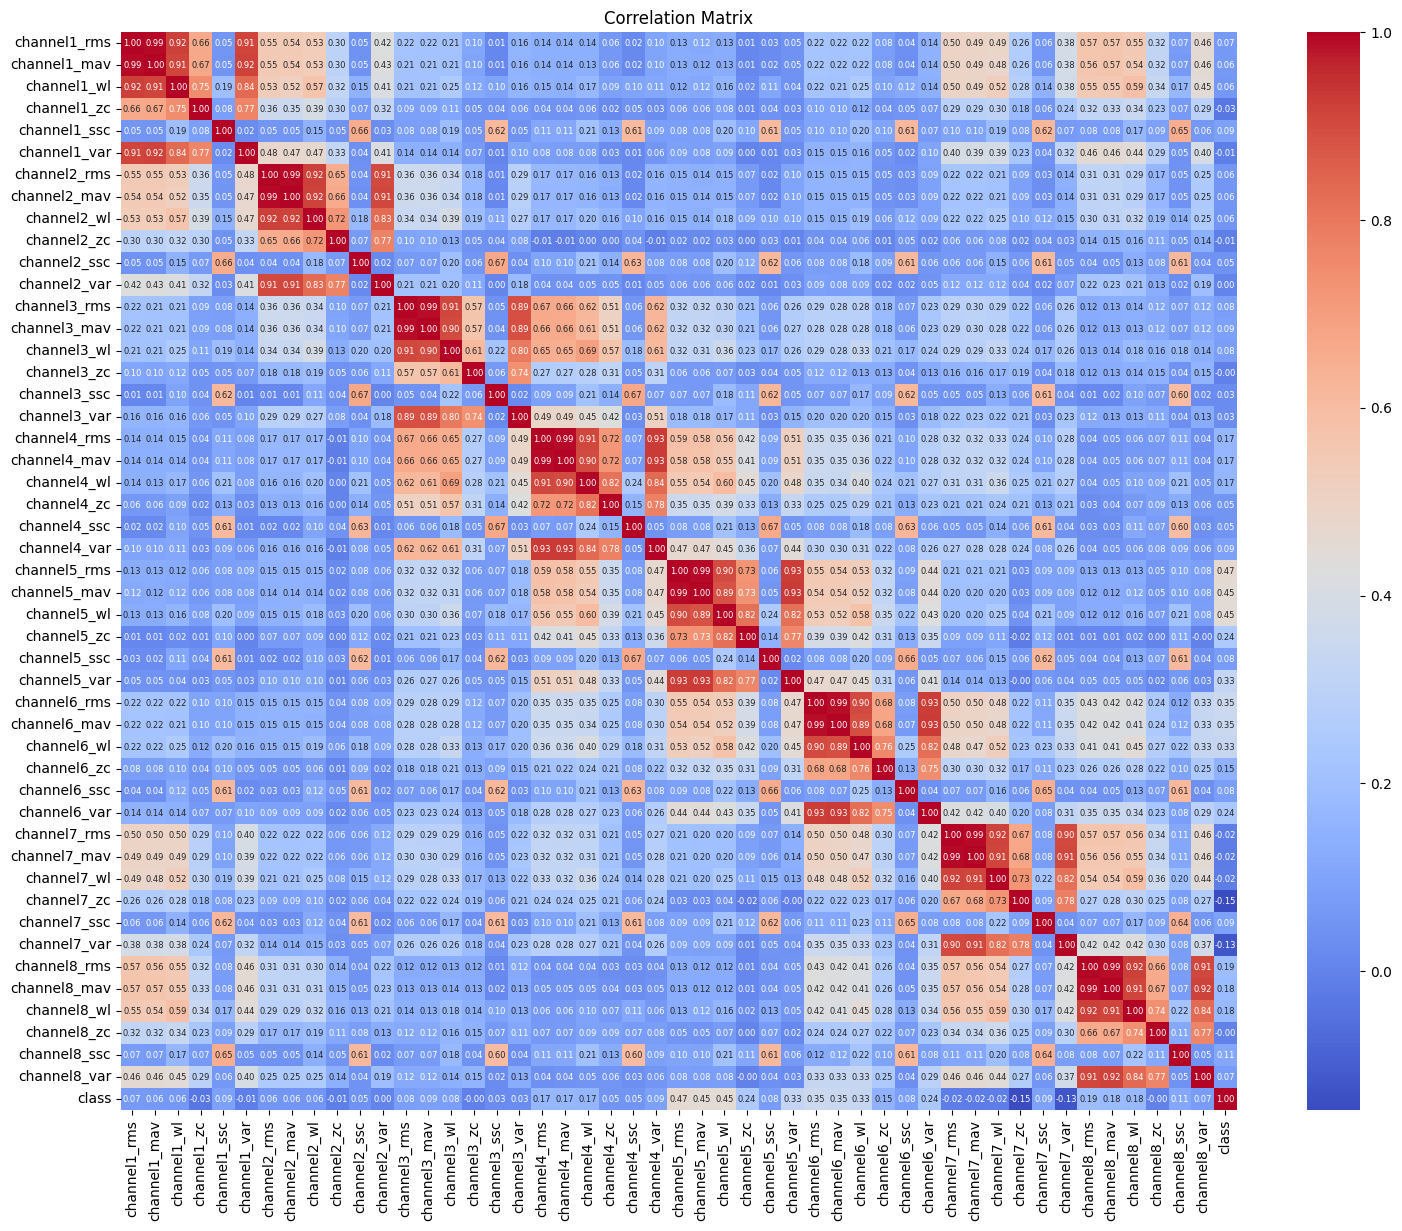

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 14))
sns.heatmap(df_features.corr(), annot=True, cmap='coolwarm',annot_kws={"size": 6}, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

as we see The dataset is imbalanced.

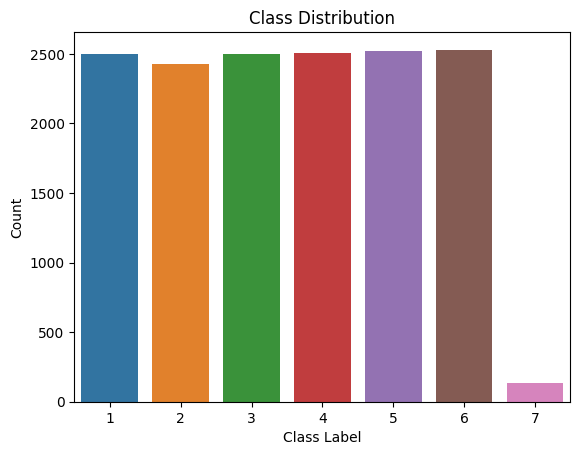

In [91]:

sns.countplot(data=df_features, x='class')
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()


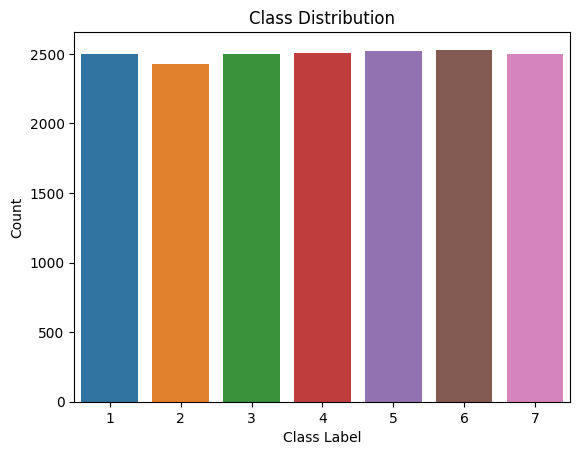

In [99]:
from sklearn.utils import resample
import pandas as pd



df_class7 = df_features[df_features['class'] == 7]
df_others = df_features[df_features['class'] != 7]


df_class7_upsampled = resample(
    df_class7,
    replace=True,
    n_samples=2500,  # target sample value
    random_state=42
)

# Tüm veriyi birleştir
df_balanced = pd.concat([df_others, df_class7_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)  
X_resampled = df_balanced.drop(columns=['class'])
y_balanced = df_balanced['class']


num_classes = y_balanced.nunique()
num_classes = y_balanced.max() + 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)



sns.countplot(x = y_balanced)
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()


Epoch 1/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6873 - loss: 0.9259 - val_accuracy: 0.8211 - val_loss: 0.5006
Epoch 2/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8326 - loss: 0.4745 - val_accuracy: 0.8465 - val_loss: 0.4246
Epoch 3/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8603 - loss: 0.3982 - val_accuracy: 0.8625 - val_loss: 0.3796
Epoch 4/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8749 - loss: 0.3491 - val_accuracy: 0.8765 - val_loss: 0.3461
Epoch 5/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8811 - loss: 0.3196 - val_accuracy: 0.8763 - val_loss: 0.3416
Epoch 6/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8977 - loss: 0.2945 - val_accuracy: 0.8848 - val_loss: 0.3216
Epoch 7/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8962 - loss: 0.2845 - val_accuracy: 0.8940 - val_loss: 0.3062
Epoch 8/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9065 - loss: 0.2656 - val_accuracy: 0.

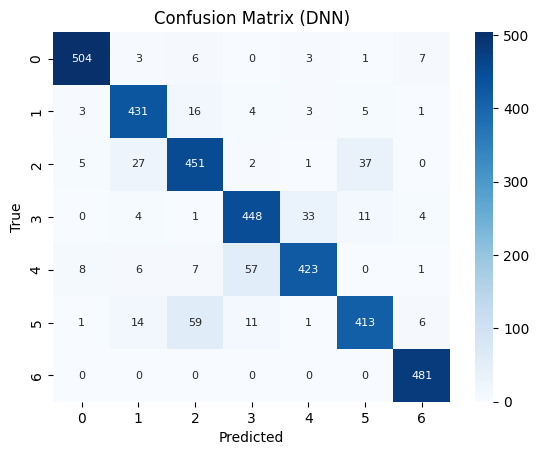

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_balanced, test_size=0.2, random_state=42)



early_stop = EarlyStopping(
    monitor='val_loss',     
    patience=5,             
    restore_best_weights=True 
)

y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test,  num_classes)

# DNN modeli
nn_model = Sequential()
nn_model.add(Input(shape=(X_train.shape[1],)))
#nn_model.add(Dense(256, activation='tanh'))

nn_model.add(Dense(128, activation='tanh'))
Dropout(0.3)
nn_model.add(Dense(64, activation='tanh'))
Dropout(0.3)
nn_model.add(Dense(32, activation='tanh'))

nn_model.add(Dense(num_classes, activation='softmax'))  # çok sınıflıysa softmax

# Derleme
nn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

nn_model.fit(X_train,y_train_cat,batch_size=40,epochs=40,callbacks=[early_stop], validation_data=(X_test,y_test_cat),)


y_pred_probs = nn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


y_test_labels = np.argmax(y_test_cat, axis=1)

# 3. Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 8}, cmap='Blues')
plt.title("Confusion Matrix (DNN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [103]:
from sklearn.metrics import classification_report

y_test_labels = np.argmax(y_test_cat, axis=1)

print(classification_report(y_test_labels, y_pred, digits=4))

              precision    recall  f1-score   support

           1     0.9674    0.9618    0.9646       524
           2     0.8887    0.9309    0.9093       463
           3     0.8352    0.8623    0.8485       523
           4     0.8582    0.8942    0.8759       501
           5     0.9116    0.8426    0.8758       502
           6     0.8844    0.8178    0.8498       505
           7     0.9620    1.0000    0.9806       481

    accuracy                         0.9005      3499
   macro avg     0.9011    0.9014    0.9006      3499
weighted avg     0.9009    0.9005    0.9001      3499

